# Assignment 06

Joel Brigida

CAP4613-001 Intro to Deep Learning

Prof. Behnaz Ghoraani

Due Date: April 17, 2023

#### Turn Off Messages & Set GPU Memory Growth:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Turn Off Messages
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Alt: 1792 MB, 2048 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from random import randint
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

#### Functions To Plot Images:

In [4]:
def dispAnImage(filepath):
    myImage = img.imread(filepath)
    plt.figure(figsize = (15, 15))
    plt.imshow(myImage)
    plt.axis('off') # Turn Off Axes for image display
    plt.show()

# plot training accuracy and loss
def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

## Problem 1) Consider the Convolutional Layer Below: 
 - Fill in the Missing cells in the activation map and output image.

<div align="center">

  <table>
    <tbody><caption>Input Image</caption>
      <tr>
        <td>0.81</td><td>0.90</td><td>0.13</td><td>0.91</td><td>0.63</td><td>0.09</td><td>0.28</td><td>0.54</td>
      </tr>
      <tr>
        <td>0.96</td><td>0.96</td><td>0.15</td><td>0.97</td><td>0.96</td><td>0.48</td><td>0.14</td><td>0.80</td>
      </tr>
      <tr>
        <td>0.42</td><td>0.91</td><td>0.79</td><td>0.22</td><td>0.66</td><td>0.03</td><td>0.84</td><td>0.93</td>
      </tr>
      <tr>
        <td>0.67</td><td>0.75</td><td>0.74</td><td>0.39</td><td>0.65</td><td>0.17</td><td>0.71</td><td>0.03</td>
      </tr>
      <tr>
        <td>0.27</td><td>0.04</td><td>0.09</td><td>0.82</td><td>0.69</td><td>0.31</td><td>0.95</td><td>0.03</td>
      </tr>
      <tr>
        <td>0.43</td><td>0.38</td><td>0.76</td><td>0.79</td><td>0.19</td><td>0.49</td><td>0.45</td><td>0.64</td>
      </tr>
      <tr>
        <td>0.70</td><td>0.75</td><td>0.28</td><td>0.68</td><td>0.66</td><td>0.16</td><td>0.12</td><td>0.49</td>
      </tr>
      <tr>
        <td>0.36</td><td>0.45</td><td>0.58</td><td>0.22</td><td>0.75</td><td>0.25</td><td>0.51</td><td>0.69</td>
      </tr>
    </tbody>
  </table>

  <br>

  <table>
    <tbody><caption>Conv Layer, ReLU:<br> 1 Filter of 5 &times; 5 &times; 1</caption>
      <tr>
        <td>-1</td><td>0</td><td>0</td><td>0</td><td>0</td>
      </tr>
      <tr>
        <td>0</td><td>1</td><td>0</td><td>0</td><td>0</td>
      </tr>
      <tr>
        <td>0</td><td>0</td><td>-1</td><td>0</td><td>0</td>
      </tr>
      <tr>
        <td>0</td><td>0</td><td>0</td><td>1</td><td>0</td>
      </tr>
      <tr>
        <td>0</td><td>0</td><td>0</td><td>0</td><td>1</td>
      </tr>
    </tbody>
  </table>

  <br>

  <table>
    <tbody><caption>Activation Map</caption>
      <tr>
        <td>0.44</td><td>-0.01</td><td>1.3</td><td>0.76</td>
      </tr>
      <tr>
        <td>0.22</td><td>0.62</td><td>0.18</td><td>1.11</td>
      </tr>
      <tr>
        <td>1.69</td><td>-0.64</td><td>-0.48</td><td>1.06</td>
      </tr>
      <tr>
        <td>0.04</td><td>-0.54</td><td>0.56</td><td>0.62</td>
      </tr>
    </tbody>
  </table>

  <br>

  <table>
    <tbody><tbody><caption>Output Image</caption>
      <tr>
        <td>0.44</td><td>0</td><td>1.3</td><td>0.76</td>
      </tr>
      <tr>
        <td>0.22</td><td>0.62</td><td>0.18</td><td>1.11</td>
      </tr>
      <tr>
        <td>1.69</td><td>0</td><td>0</td><td>1.06</td>
      </tr>
      <tr>
        <td>0.04</td><td>0</td><td>0.56</td><td>0.62</td>
      </tr>
    </tbody>
  </table>
</div>

#### Show Handwritten Work:

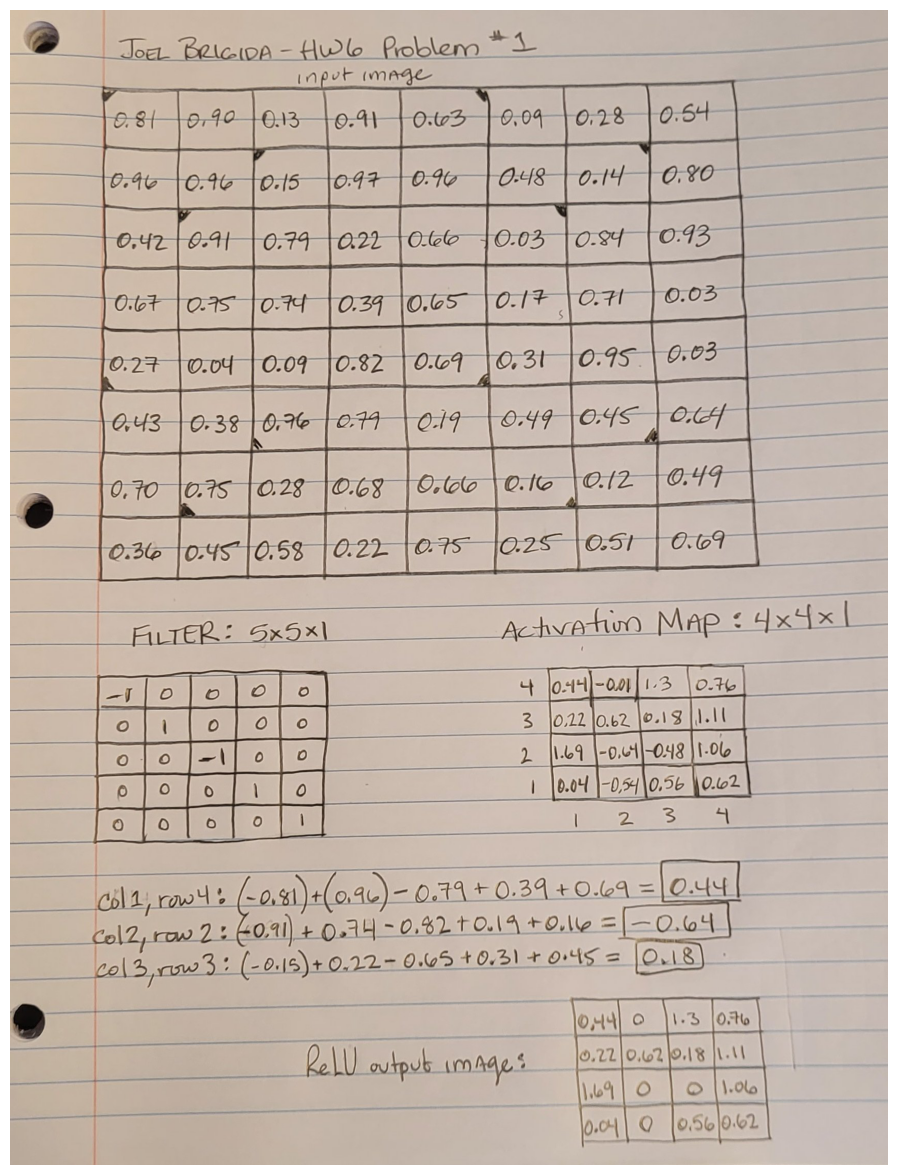

In [5]:
dispAnImage('../assets/HW6/Prob1-Soln.jpg')

## Problem 2) Consider the following CNN:
 - The input images are of the size $ 65 \times 65 \times 3 $ and the problem is a 10-class classification.
 - Answer the following questions. Show all steps in your calculation.

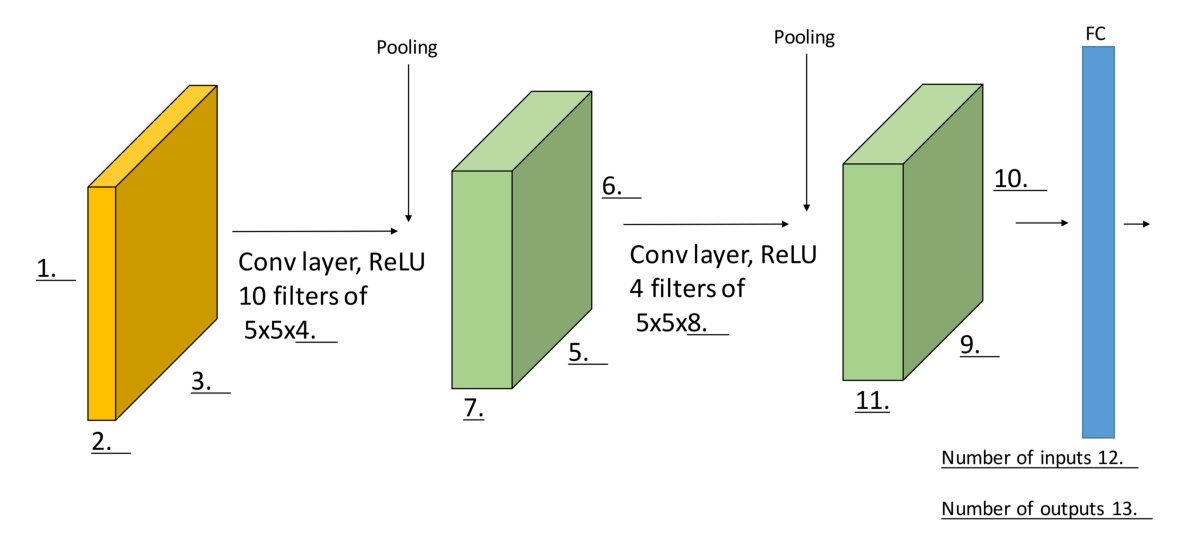

In [6]:
dispAnImage('../assets/HW6/Prob2.png')

#### Answers:

 1. $ \ 65$ 
 2. $ \ 3$
 3. $ \ 65$
 4. $ \ 3$
 5. $ \ 16$
 6. $ \ 16$
 7. $ \ 10$
 8. $ \ 10$
 9. $ \ 8$
 10. $ \ 8$
 11. $ \ 4$
 12. $ \ 2570$
 13. $ \ 10$

 - See Work In Images Below

#### 2a) Padding of 1 and stride of 2 in Conv 1; padding of 2 and stride of 1 in Conv 2. Find and report the values in the spaces 1. to 13.

#### 2b) Calculate the number of total parameters at every Conv and fully connected (FC) layer.

#### 2c) Find the total number of parameters of the entire neural network.

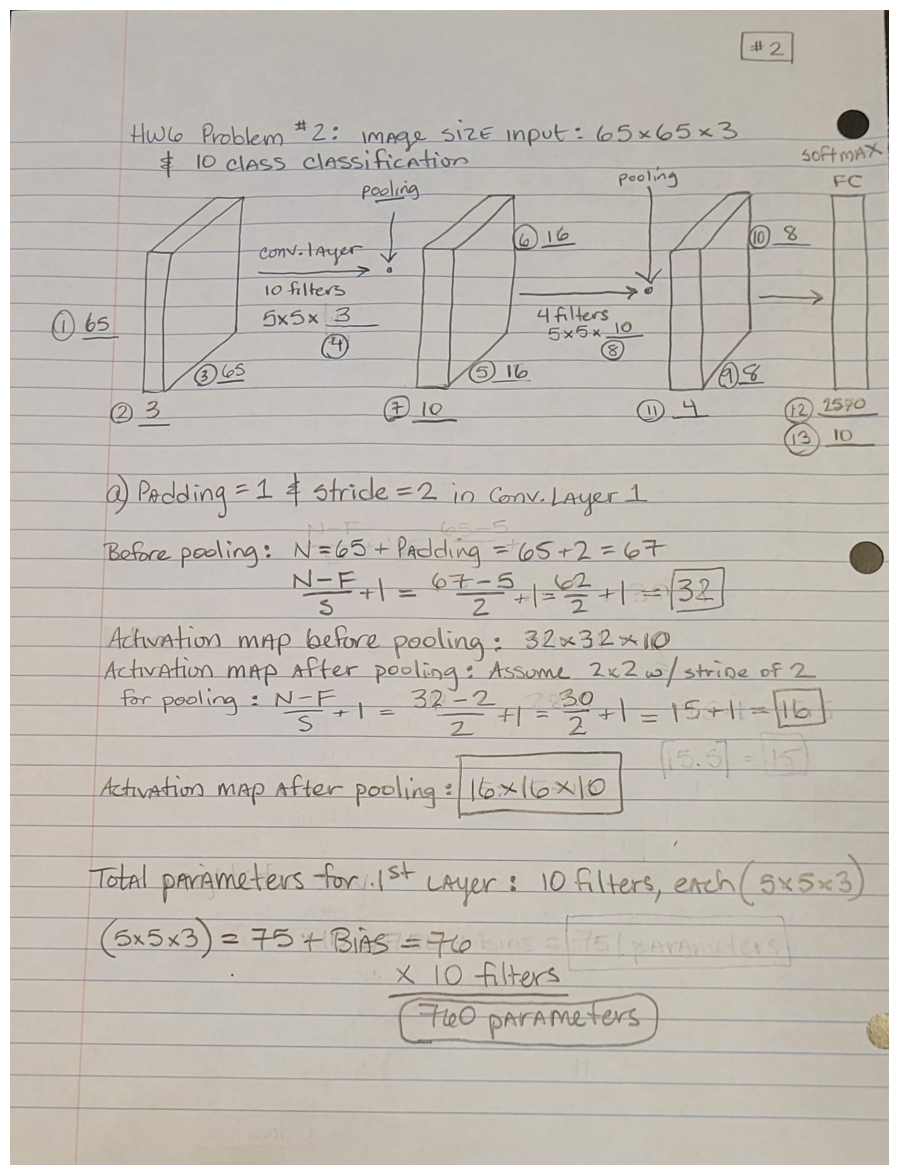

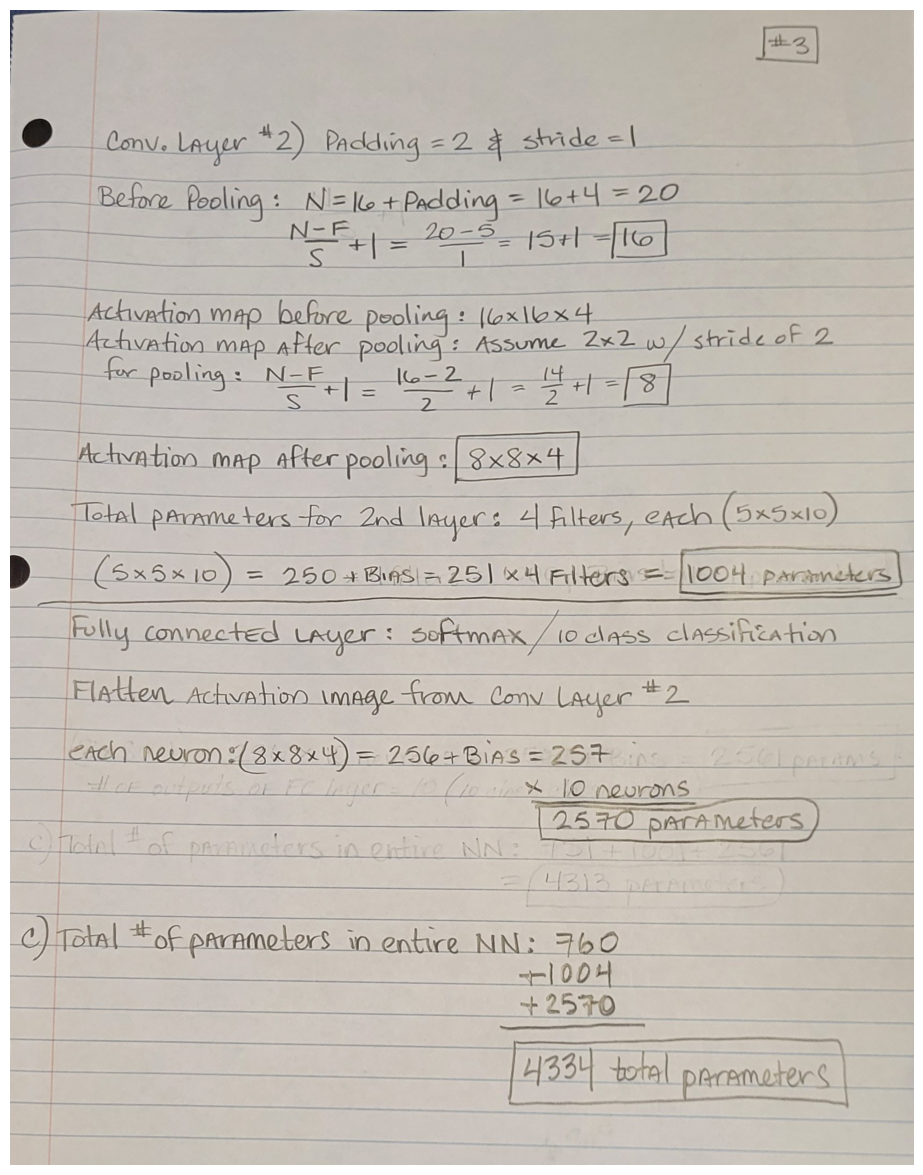

In [7]:
dispAnImage('../assets/HW6/Prob2-1Soln.jpg')
dispAnImage('../assets/HW6/Prob2-2Soln.jpg')

## Problem 3) Keras: Convolutional Neural Network (CNN), 10-class classifier for CIFAR-10 dataset:

 - a) Use `cifar10` function in `keras.datasets` to load CIFAR-10 dataset. Split it into the training and testing sets. Define a validation set by randomly selecting 20% of the training images along with their corresponding labels. This will be the `validation_data`.
 - b) Scale the pixel values of the images in all the sets to a value between 0 and 1. Perform this process by dividing the image values with 255. Note: No need to flatten the images.
 - c) Convert the label vectors for all the sets to binary class matrices using `to_categorical()` Keras function.
 - d) Using Keras library, build a CNN with the following design: 2 convolutional blocks, 1 flattening layer, 1 FC layer with 512 nodes, and 1 output layer. Each convolutional block consists of two back-to-back Conv layers followed by max pooling. The filter size is $3 \times 3$ image_depth. The number of filters is 32 in the first convolutional block and 64 in the second block. Use the following network architecture as a reference:

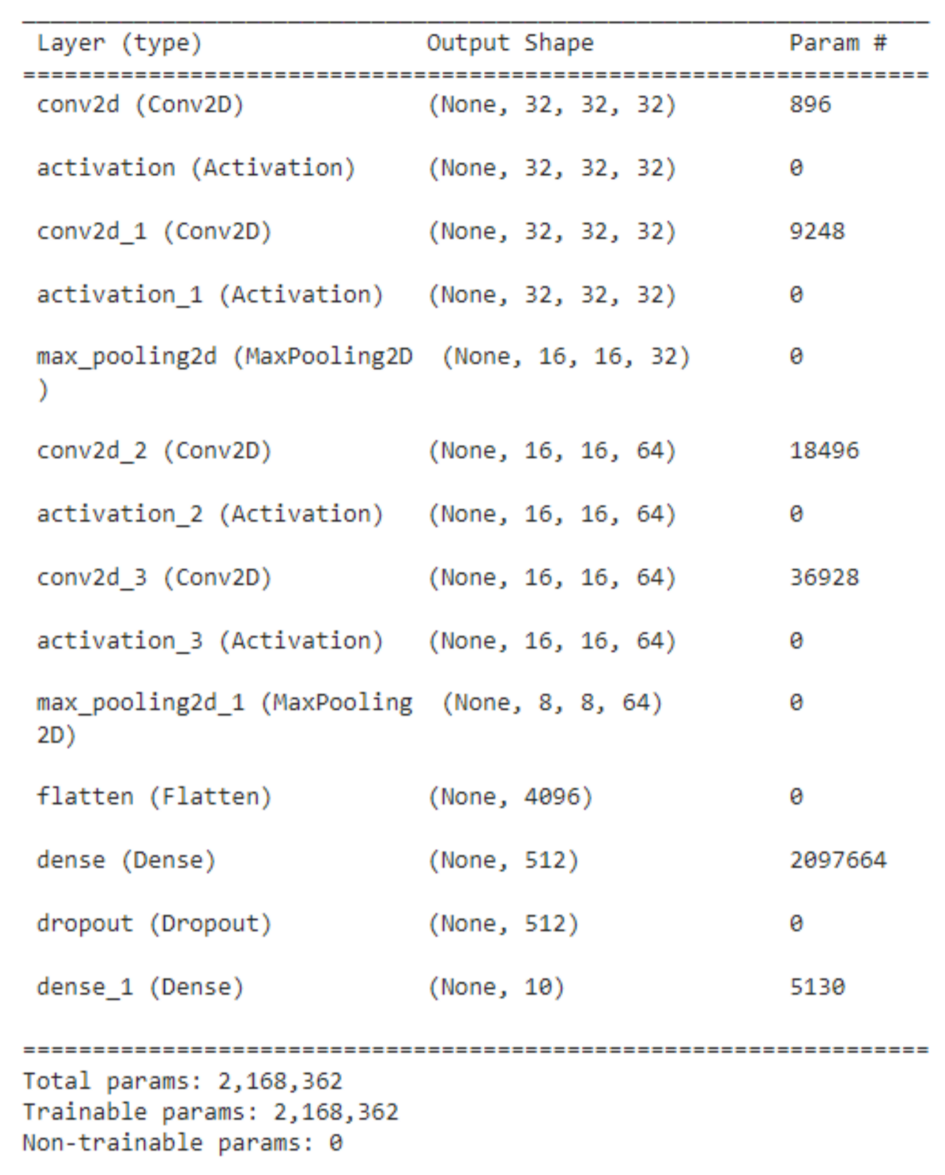

In [8]:
dispAnImage('../assets/HW6/Prob3.png')

e) Compile, train, and then evaluate:
 - i. Compile the network. Make sure to select a correct loss function for this classification problem. Use `Adam` optimizer (Adam: learning rate of $0.001$).
 - ii. Use `ModelCheckpoint` to save the best model based on the lowest validation loss.
 - iii. Train the network for 50 epochs with a batch size of 32. Remember to assign the validation set to `validation_data` in the fit function.
 - iv. Plot the training and validation loss for all the epochs in one plot. 
 - v. Use the `evaluate()` Keras function to find the training and validation loss and the accuracy. Report the results.

f) Now define another model with the same architecture in (d) and then:
 - i. Compile the network. Make sure to select a correct loss function for this classification problem. Use `Adam` optimizer (Adam: learning rate of $0.001$).
 - ii. Use `ModelCheckpoint` to save the best model based on the lowest validation loss.
 - iii. Create an image data generator in Keras for real-time data augmentation. The augmentation operations are rotation (10 degrees range), width and height. shift (0.1 range), and horizontal flip.
 - iv. Train the network for 50 epochs with a batch size of 32. Remember to use the image data generator. Assign the validation set to `validation_data` in the fit function.
 - v. Plot the training and validation loss for all the epochs in one plot. 
 - vi. Use the `evaluate()` Keras function to find the training and validation loss and the accuracy. Report the results.

g) What do you observe from the validation loss in both step (e) and (f)? Is the model overfitting or underfitting the training data? Explain.

h) Now define another model with the same architecture in (d), except that this time you need to add batch normalization layers to the CNN network.
 - i. Add normalization layer after all the convolutional and fully connected layers (not the output layer). Add them before the activation layers and be noted that there is no need for the bias in the convolutional or fully connected layers.
 - ii. Compile the network. Make sure to select a correct loss function for this classification problem. Use `Adam` optimizer (Adam: learning rate of $0.01$).
 - iii. Use `ModelCheckpoint` to save the best model based on the lowest validation loss.
 - iv. Train the network for 50 epochs with a batch size of 64. Remember to assign the validation set to `validation_data` in the fit function.
 - v. Plot the training and validation loss for all the epochs in one plot.
 - vi. Use the `evaluate()` Keras function to find the training and validation loss and

i) What do you observe from the training loss in both steps (e) and (h)? Explain.

#### Import Data:

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = np.arange(10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Randomize & Select 20% of Images For Validation:

In [10]:
num_train_img = x_train.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
print(train_ind)
print(train_ind_s, '\n')

x_train = x_train[train_ind_s,:,:,:]
y_train = y_train[train_ind_s]
print(x_train.shape)
print(y_train.shape, '\n')

x_val = x_train[0:int(0.2 * num_train_img),:,:,:]
y_val = y_train[0:int(0.2 * num_train_img)]
print(x_val.shape)
print(y_val.shape, '\n')

x_train = x_train[int(0.2 * num_train_img):,:,:]
y_train = y_train[int(0.2 * num_train_img):]
print(x_train.shape)
print(y_train.shape, '\n')

[    0     1     2 ... 49997 49998 49999]
[ 8350 28984 37441 ... 12324 40466 11818] 

(50000, 32, 32, 3)
(50000, 1) 

(10000, 32, 32, 3)
(10000, 1) 

(40000, 32, 32, 3)
(40000, 1) 



#### Plot 10 Images From Randomized Data:

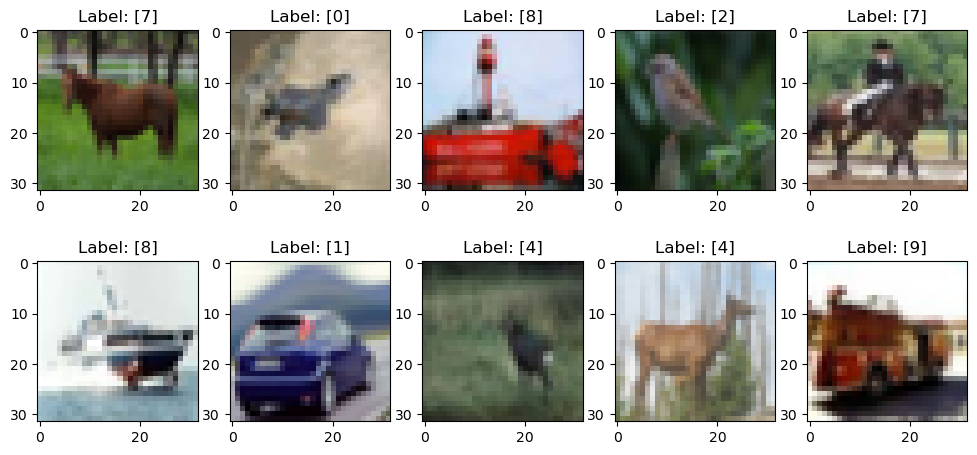

In [11]:
img_plt(x_train[0:10,:,:,:], y_train[0:10]) # plot the images

#### Scaling The Images to $ [0, \ 1] $:

In [12]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

#### Convert Class Vectors to Binary Class Matrices:

In [13]:
y_train_c = to_categorical(y_train, len(classes))
y_val_c = to_categorical(y_val, len(classes))
y_test_c = to_categorical(y_test, len(classes))

### Model 1: CNN Without Data Augmentation Or Batch Normalization:

#### Define The Model:

In [14]:
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model1.add(Dense(units=512, activation='relu'))
model1.add(Dropout(0.5)) # Helps to reduce overfitting
model1.add(Dense(units=len(classes), activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0

#### Compile Network:

 - Use `Adam` optimizer with `learning_rate = 0.001`

In [15]:
opt1 = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='categorical_crossentropy', optimizer=opt1, metrics=['accuracy'])

#### Save Best Model:

 - use `ModelCheckpoint` to save best model based on lowest `val_loss`

In [16]:
save_path1 = '../assets/HW6/model1_ckpt.h5'
callbacks_save1 = ModelCheckpoint(save_path1, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

#### Fit & Train The Network:

 - Plot Accuracy and Loss Statistics

Epoch 1/3
1250/1250 [==============================] - 36s 24ms/step - loss: 1.7776 - accuracy: 0.3434 - val_loss: 1.1622 - val_accuracy: 0.5907
Epoch 2/3
1250/1250 [==============================] - 46s 37ms/step - loss: 1.1233 - accuracy: 0.6025 - val_loss: 0.9311 - val_accuracy: 0.6700
Epoch 3/3
1250/1250 [==============================] - 37s 30ms/step - loss: 0.8829 - accuracy: 0.6865 - val_loss: 0.8286 - val_accuracy: 0.7094

Training Accuracy: 69.012 %
Training Loss: 0.8743


Validation Accuracy: 70.94 %
Validation Loss: 0.8286



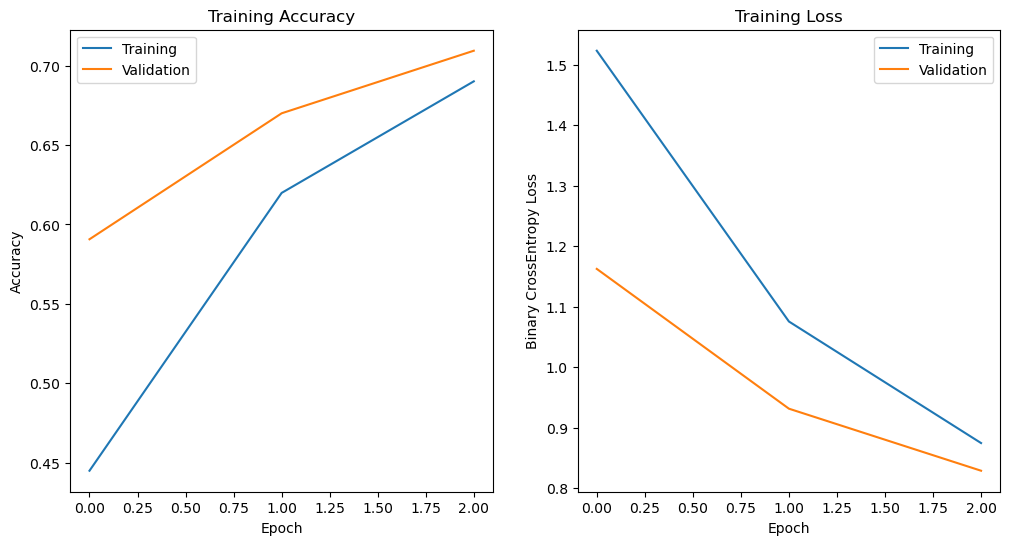

In [17]:
history1 = model1.fit(x_train, y_train_c, epochs = 3, 
                      batch_size = 32, verbose = 1, 
                      validation_data=(x_val, y_val_c),
                      callbacks=[callbacks_save1])

plotEverything(history1)

#### Load Best Model & Evaluate:

In [18]:
model1a = load_model(save_path1)

score1a = model1a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score1a[0]}')
print(f'Accuracy From Training Set: {score1a[1] * 100} %\n')

score1b = model1a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score1b[0]}')
print(f'Accuracy From Validation Set: {score1b[1] * 100} %\n')

score1c = model1a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score1c[0]}')
print(f'Accuracy From Testing Set: {score1c[1] * 100} %\n')

1250/1250 [==============================] - 7s 6ms/step - loss: 0.6482 - accuracy: 0.7757
Total Loss From Training Set: 0.6481848359107971
Accuracy From Training Set: 77.56749987602234 %

313/313 [==============================] - 3s 9ms/step - loss: 0.8286 - accuracy: 0.7094
Total Loss From Validation Set: 0.828598141670227
Accuracy From Validation Set: 70.93999981880188 %

313/313 [==============================] - 3s 9ms/step - loss: 0.8226 - accuracy: 0.7092
Total Loss From Testing Set: 0.8225714564323425
Accuracy From Testing Set: 70.92000246047974 %



### Model 2: Real-Time Data Augmentation:

#### Define The Model:

In [19]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model2.add(Dense(units=512, activation='relu'))
model2.add(Dropout(0.5)) # Helps to reduce overfitting
model2.add(Dense(units=len(classes), activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)       

#### Compile Network:

 - Use `Adam` optimizer with `learning_rate = 0.001`

In [20]:
opt2 = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=['accuracy'])

#### Save Best Model:

 - use `ModelCheckpoint` to save best model based on lowest `val_loss`

In [21]:
save_path2 = '../assets/HW6/model2_ckpt.h5'
callbacks_save2 = ModelCheckpoint(save_path2, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

#### Create A Data Generator For Real-Time Data Augmentation

In [22]:
datagen2 = ImageDataGenerator(
    #shear_range = -0.1,
    #zoom_range = -0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#datagen2.fit(x_train) # not required?

#### Fit The Model Using The Data Generator & Plot Statistics:

Epoch 1/3
1250/1250 [==============================] - 29s 23ms/step - loss: 1.8185 - accuracy: 0.3251 - val_loss: 1.2355 - val_accuracy: 0.5591
Epoch 2/3
1250/1250 [==============================] - 28s 22ms/step - loss: 1.2977 - accuracy: 0.5329 - val_loss: 1.0541 - val_accuracy: 0.6217
Epoch 3/3
1250/1250 [==============================] - 29s 24ms/step - loss: 1.1159 - accuracy: 0.5964 - val_loss: 0.9167 - val_accuracy: 0.6746

Training Accuracy: 61.255 %
Training Loss: 1.0806


Validation Accuracy: 67.46 %
Validation Loss: 0.9167



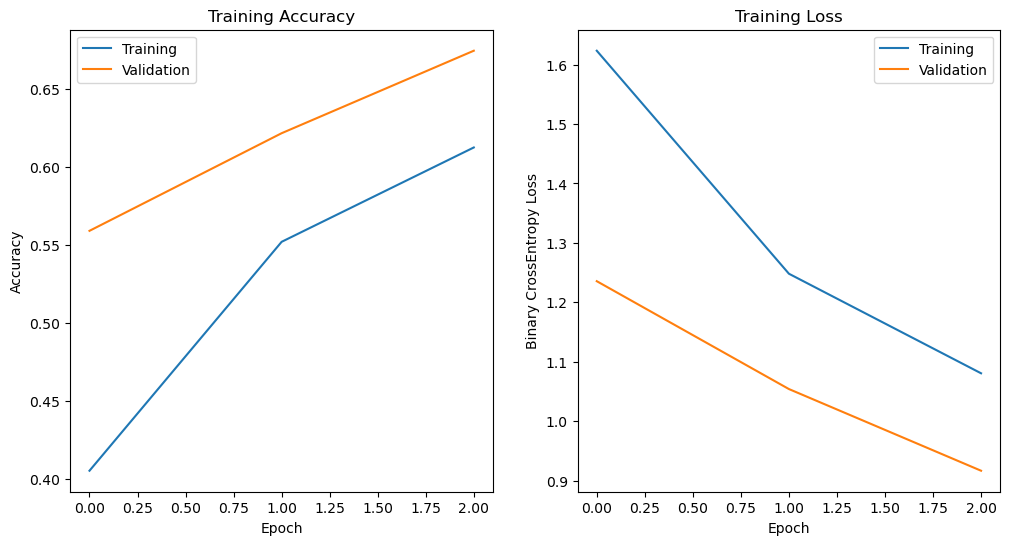

In [23]:
history2 = model2.fit(datagen2.flow(x_train, y_train_c, batch_size=32), 
                      epochs=3, verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save2])

plotEverything(history2)

#### Load Best Model & Evaluate:

In [24]:
model2a = load_model(save_path2)

score2a = model2a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score2a[0]}')
print(f'Accuracy From Training Set: {score2a[1] * 100} %\n')

score2b = model1a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score2b[0]}')
print(f'Accuracy From Validation Set: {score2b[1] * 100} %\n')

score2c = model1a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score2c[0]}')
print(f'Accuracy From Testing Set: {score2c[1] * 100} %\n')

1250/1250 [==============================] - 7s 6ms/step - loss: 0.8636 - accuracy: 0.6931
Total Loss From Training Set: 0.8635897636413574
Accuracy From Training Set: 69.3149983882904 %

313/313 [==============================] - 3s 9ms/step - loss: 0.8286 - accuracy: 0.7094
Total Loss From Validation Set: 0.828598141670227
Accuracy From Validation Set: 70.93999981880188 %

313/313 [==============================] - 3s 9ms/step - loss: 0.8226 - accuracy: 0.7092
Total Loss From Testing Set: 0.8225714564323425
Accuracy From Testing Set: 70.92000246047974 %



##### What do you observe from the validation loss in both step (e) and (f)?

 - step (e) = Model 1
 - step (f) = Model 2

##### Is the model overfitting or underfitting the training data? Explain.

##### --Insert Response Here--

### Model 3: Batch Normalization & Real-Time Data Augmentation:

#### Define The Model:

 - Add Batch Normalization after all convolutional & fully connected layers.
 - Batch Normalization should be before the activation layers.

In [25]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model3.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten()) # Optional: Flattens 2D images to 1D Array
model3.add(Dense(units=512))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.5)) # Helps to reduce overfitting
model3.add(Dense(units=len(classes)))
model3.add(BatchNormalization())
model3.add(Activation('softmax'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        864       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

#### Compile Network:

 - Use `Adam` optimizer with `learning_rate = 0.01`

In [26]:
opt3 = tf.keras.optimizers.Adam(learning_rate=0.01)
model3.compile(loss='categorical_crossentropy', optimizer=opt3, metrics=['accuracy'])

#### Save Best Model:

 - use `ModelCheckpoint` to save best model based on lowest `val_loss`

In [27]:
save_path3 = '../assets/HW6/model3_ckpt.h5'
callbacks_save3 = ModelCheckpoint(save_path3, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

#### Create A Data Generator For Real-Time Data Augmentation

In [28]:
datagen3 = ImageDataGenerator(
    #shear_range = -0.1,
    #zoom_range = -0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#datagen3.fit(x_train) # not required?

#### Fit The Model Using The Data Generator & Plot Statistics:

Epoch 1/3
625/625 [==============================] - 45s 61ms/step - loss: 1.6068 - accuracy: 0.4280 - val_loss: 1.7381 - val_accuracy: 0.4768
Epoch 2/3
625/625 [==============================] - 39s 63ms/step - loss: 1.0705 - accuracy: 0.6216 - val_loss: 1.0458 - val_accuracy: 0.6565
Epoch 3/3
625/625 [==============================] - 34s 55ms/step - loss: 0.9215 - accuracy: 0.6763 - val_loss: 0.9966 - val_accuracy: 0.6703

Training Accuracy: 68.208 %
Training Loss: 0.9085


Validation Accuracy: 67.03 %
Validation Loss: 0.9966



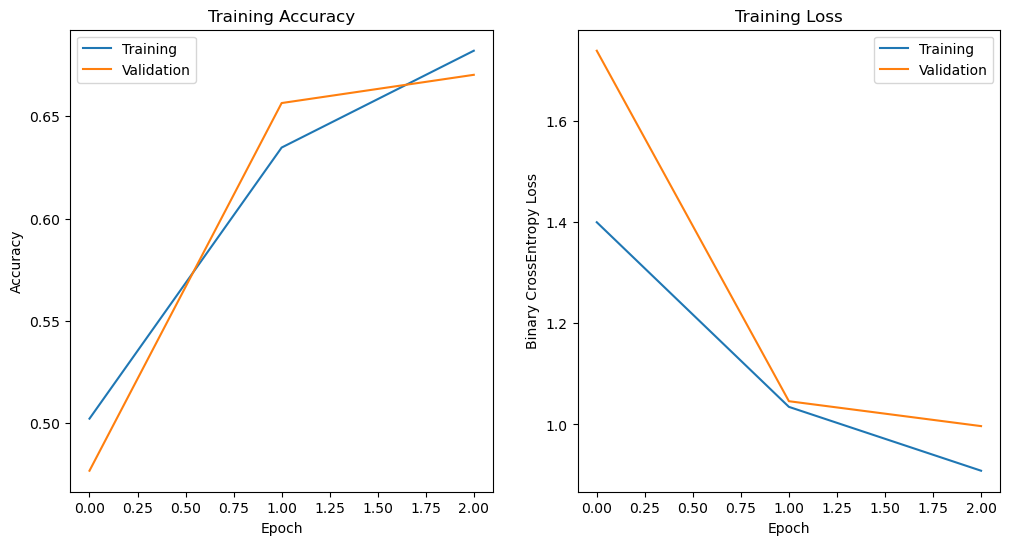

In [29]:
history3 = model3.fit(datagen3.flow(x_train, y_train_c, batch_size=64), 
                      epochs=3, verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save3])

plotEverything(history3)

#### Load Best Model & Evaluate:

In [30]:
model2a = load_model(save_path2)

score2a = model2a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score2a[0]}')
print(f'Accuracy From Training Set: {score2a[1] * 100} %\n')

score2b = model1a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score2b[0]}')
print(f'Accuracy From Validation Set: {score2b[1] * 100} %\n')

score2c = model1a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score2c[0]}')
print(f'Accuracy From Testing Set: {score2c[1] * 100} %\n')

1250/1250 [==============================] - 8s 6ms/step - loss: 0.8636 - accuracy: 0.6931
Total Loss From Training Set: 0.8635897636413574
Accuracy From Training Set: 69.3149983882904 %

313/313 [==============================] - 3s 10ms/step - loss: 0.8286 - accuracy: 0.7094
Total Loss From Validation Set: 0.828598141670227
Accuracy From Validation Set: 70.93999981880188 %

313/313 [==============================] - 3s 10ms/step - loss: 0.8226 - accuracy: 0.7092
Total Loss From Testing Set: 0.8225714564323425
Accuracy From Testing Set: 70.92000246047974 %



##### What do you observe from the training loss in both step (e) and (h)?

 - step (e) = Model 1
 - step (h) = Model 3

##### Explain.

##### --Insert Response Here--